# Evaluation of prior elicitation

_David Selby, Kaiserslautern, 1 February 2024_

In this notebook, we evaluate the quality of prior distributions obtained from the LLM, comparing them with real data.

## Import data

Let's import some data from a file.

In [142]:
import pandas as pd
from pathlib import Path
import os

data_dirpath = Path(os.path.abspath('')).parents[1] / 'data'
weather_filepath = data_dirpath / 'cities/cities.csv'
priors_filepath = data_dirpath / 'output/elicitation/weather.csv'

Firstly let's get the real weather data, as downloaded via the `openmeteo` package.

In [143]:
weather_df = pd.read_csv(weather_filepath)
weather_df.city = weather_df.city.apply(
    lambda x: x.strip())  # remove trailing newline
weather_df.date = pd.to_datetime(weather_df.date)
weather_df.set_index('date', inplace=True)
weather_df.head()

,temperature,precipitation,city,address,latitude,longitude
date,,,,,,
2010-12-01,10.069083,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-02,13.787833,44.100002,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-03,13.273248,0.400000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-04,9.221168,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-05,9.531584,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221


Next we want the prior distributions for these cities as obtained with the LLM.

In [144]:
priors_df = pd.read_csv(priors_filepath)
priors_df.timestamp = pd.to_datetime(priors_df.timestamp)
priors_df.head()

,field,target,dist,model,role,shelf,roulette,timestamp,params.mean,params.precision,params.shape,params.scale
0,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0
1,New York City,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,0.5,0.01,2.0,5.0
2,London,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,1.5
3,Sydney,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,21.0,0.01,5.0,5.0
4,Cape Town,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,18.5,0.01,2.0,5.0


# Plotting the observations

What do the real data look like?

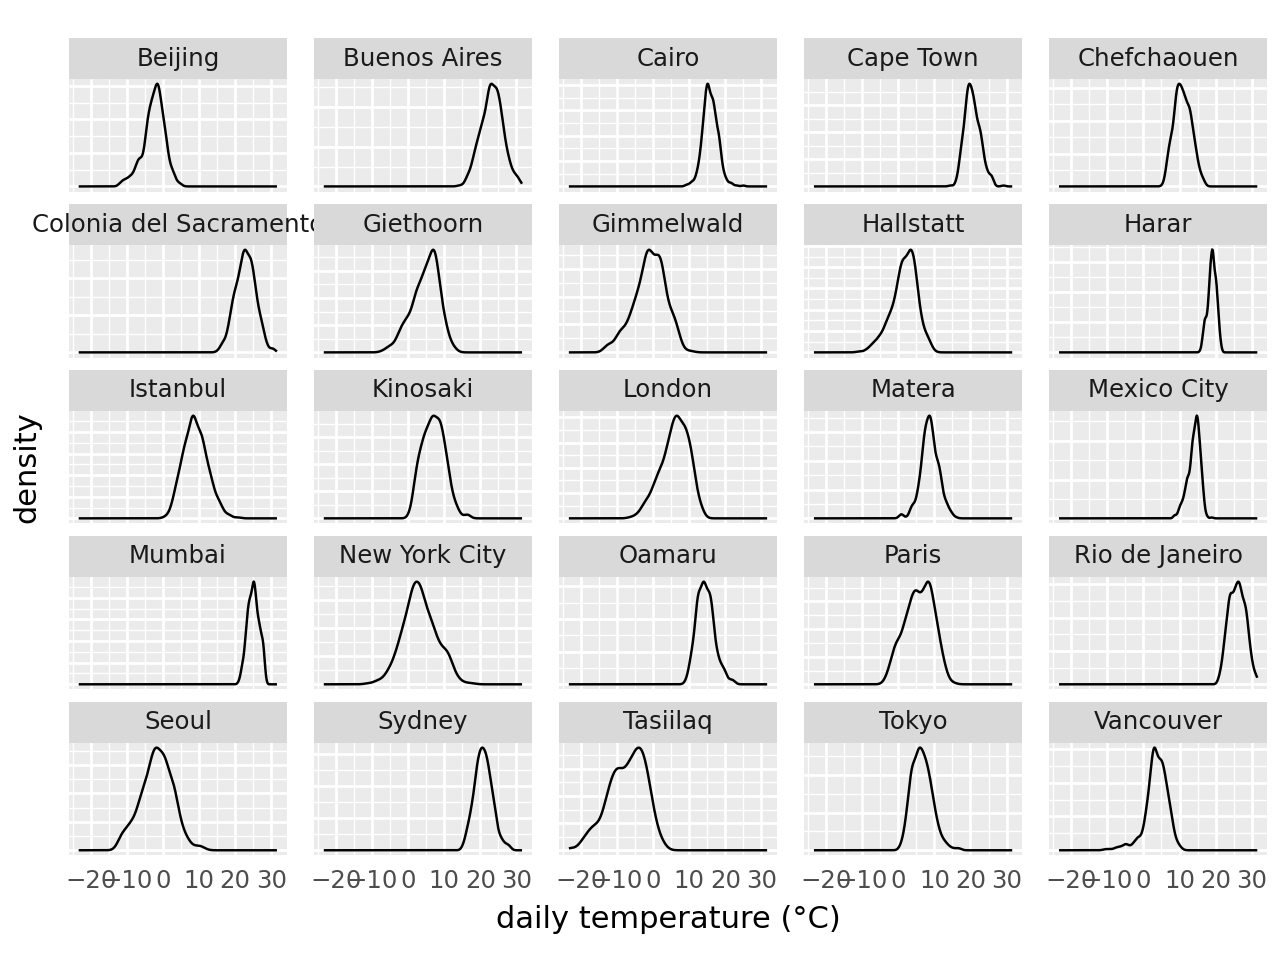

<Figure Size: (640 x 480)>

In [145]:
from plotnine import *

(
    ggplot(weather_df) + aes('temperature') +
    geom_density() +
    facet_wrap('~ city', scales='free_y', ncol=5) +
    xlab('daily temperature (°C)') +
    theme(axis_ticks=element_blank(), axis_text_y=element_blank())
)

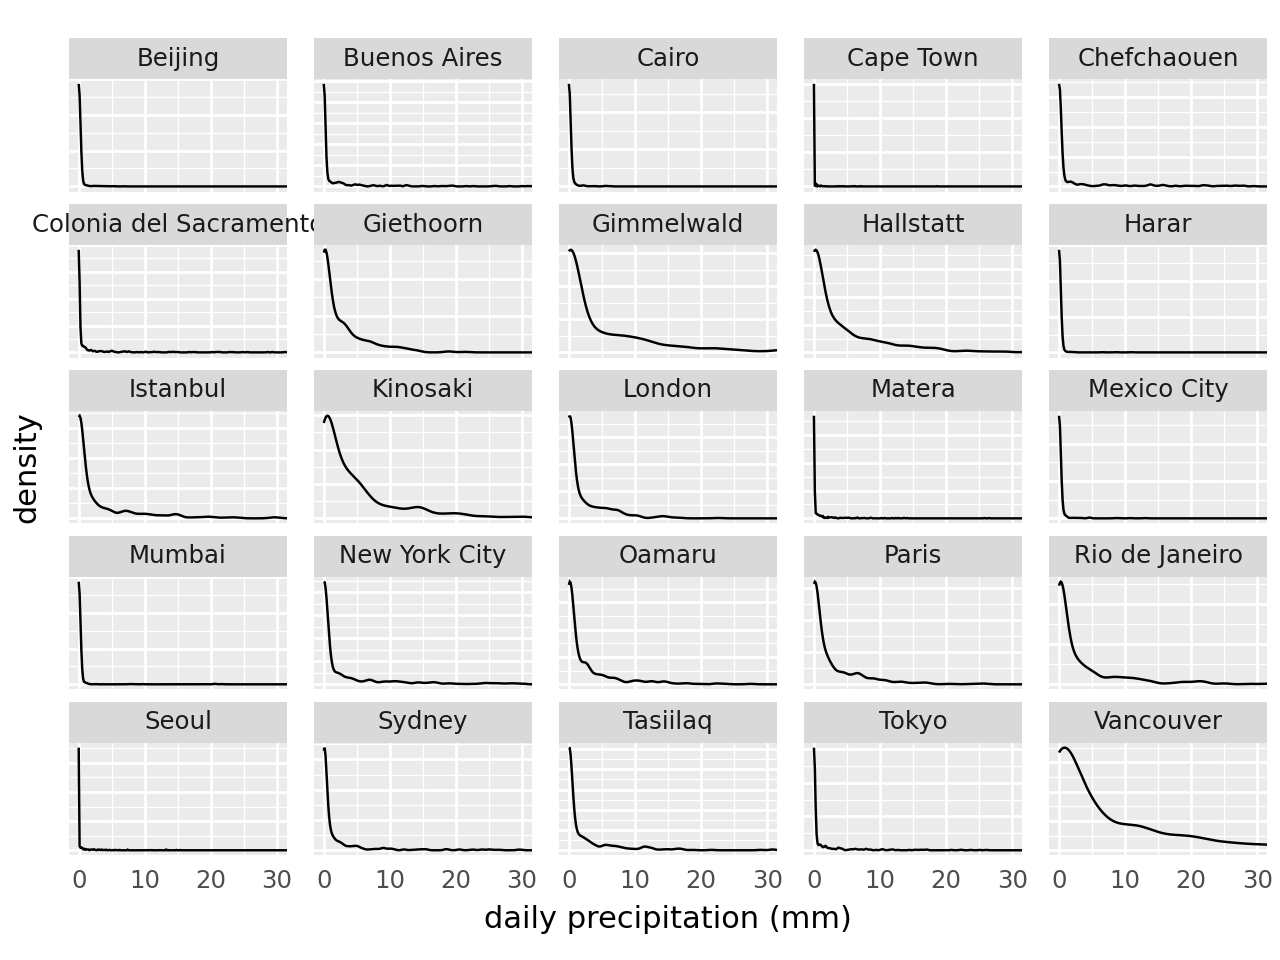

<Figure Size: (640 x 480)>

In [146]:
(
    ggplot(weather_df) + aes('precipitation') +
    geom_density() +
    facet_wrap('~ city', scales='free_y', ncol=5) +
    xlab('daily precipitation (mm)') +
    theme(axis_ticks=element_blank(), axis_text_y=element_blank()) +
    coord_cartesian(xlim=(0, 30))
)

We can also plot the monthly total precipitation, but if daily precipitation is an exponential random variable, then the sum of (independent) daily precipitation would be distributed gamma. Not only is this less skewed, it gives us less data and there is no nice formula for the predictive distribution of a gamma prior for a gamma likelihood...

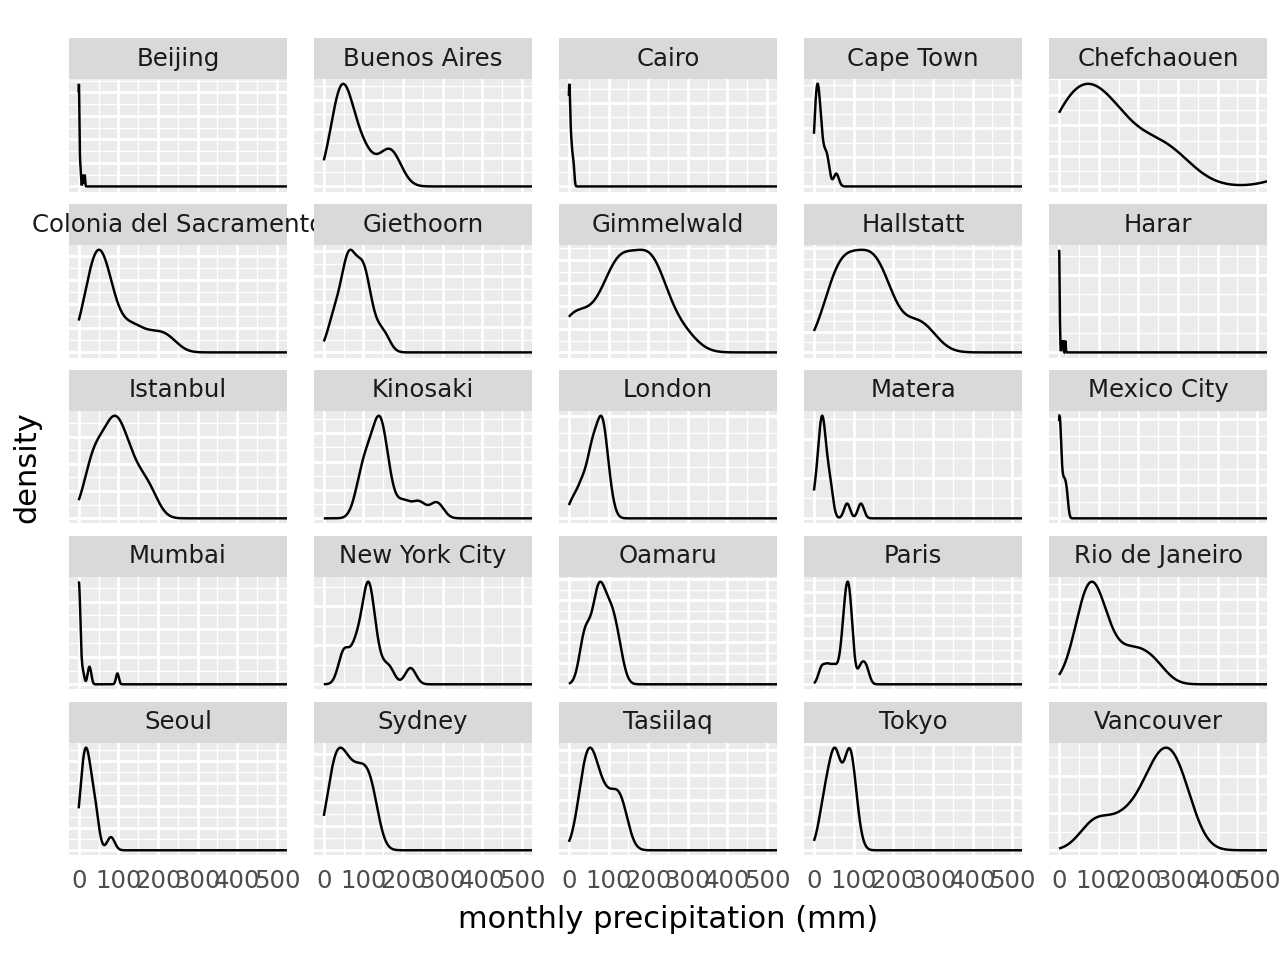

<Figure Size: (640 x 480)>

In [147]:
agg_dict = {
    'temperature': ['mean', 'std'],
    'precipitation': ['sum', 'std'],
    'latitude': 'first',
    'longitude': 'first'
}
weather_monthly = weather_df.groupby(
    ['city', weather_df.index.year]).agg(agg_dict)
weather_monthly.columns = [
    '_'.join(c) for c in weather_monthly.columns.to_flat_index()]  # tidying

(ggplot(weather_monthly.reset_index()) +
 aes('precipitation_sum') +
 geom_density() +
 xlab('monthly precipitation (mm)') +
 facet_wrap('~ city', scales='free_y', ncol=5) +
 theme(axis_ticks=element_blank(), axis_text_y=element_blank()) +
 coord_cartesian(xlim=(0, 500))
 )

## Plotting the priors

### Gamma distribution

We imposed the restriction that precipitation must have an exponential distribution and hence elicited a conjugate gamma prior distribution for the rate parameter $\theta$. Hence we're interested in daily precipitation in the month, not total precipitation.

In [148]:
priors_df[priors_df.target == 'precipitation'].head()

,field,target,dist,model,role,shelf,roulette,timestamp,params.mean,params.precision,params.shape,params.scale
25,Tokyo,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,NaN,NaN,2.5,10.0
26,New York City,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,NaN,NaN,2.0,10.0
27,London,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,NaN,NaN,2.0,10.0
28,Sydney,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,NaN,NaN,2.0,10.0
29,Cape Town,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,NaN,NaN,2.0,10.0


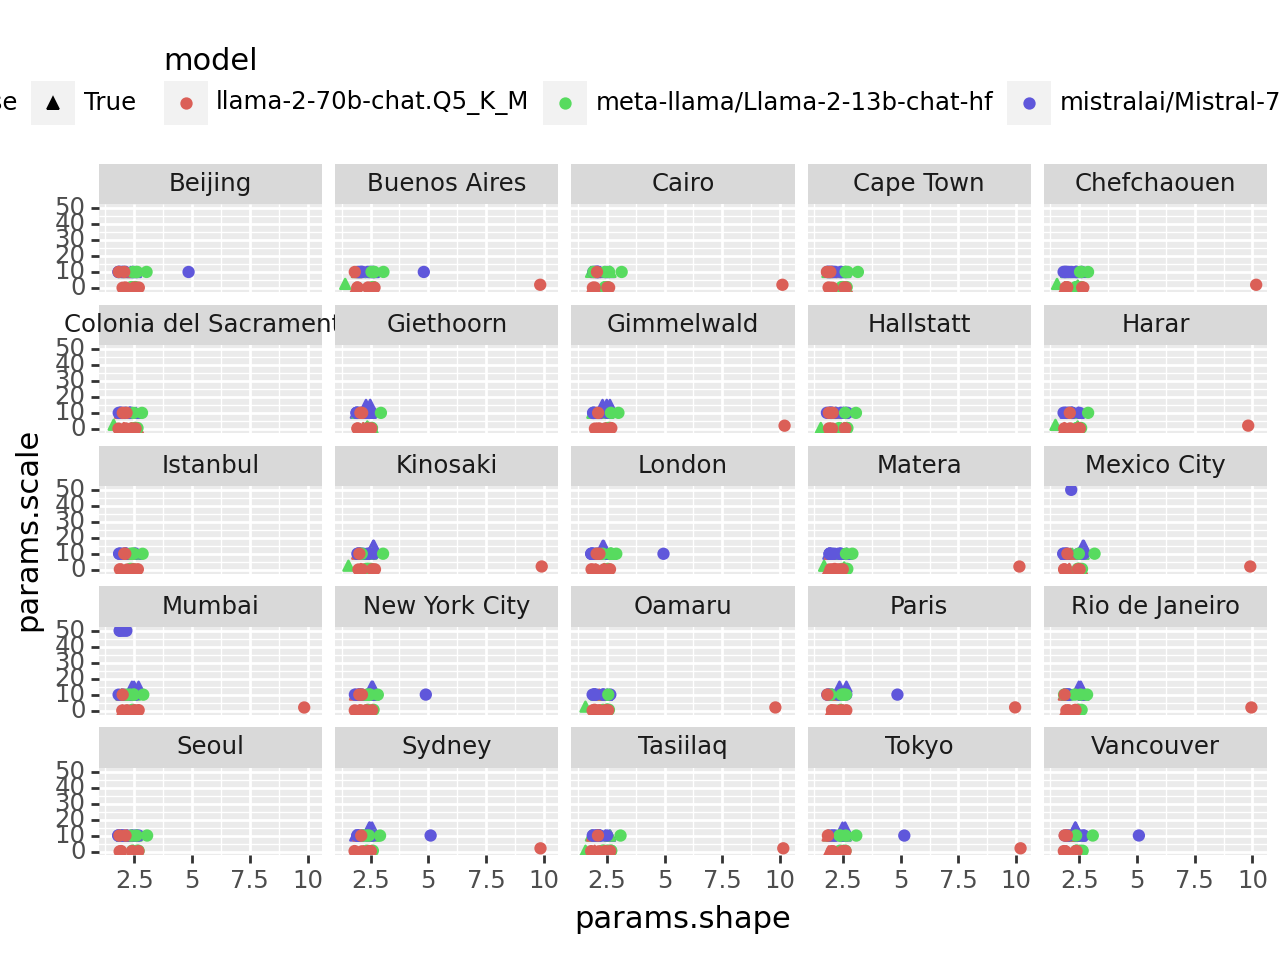

<Figure Size: (640 x 480)>

In [149]:
(
    ggplot(priors_df[priors_df.target == 'precipitation']) +
    aes('params.shape', 'params.scale', shape='shelf', colour='model') +
    geom_jitter() +
    # geom_text(aes(label='field')) +
    facet_wrap('~field', ncol=5) +
    theme(legend_position='top')
)

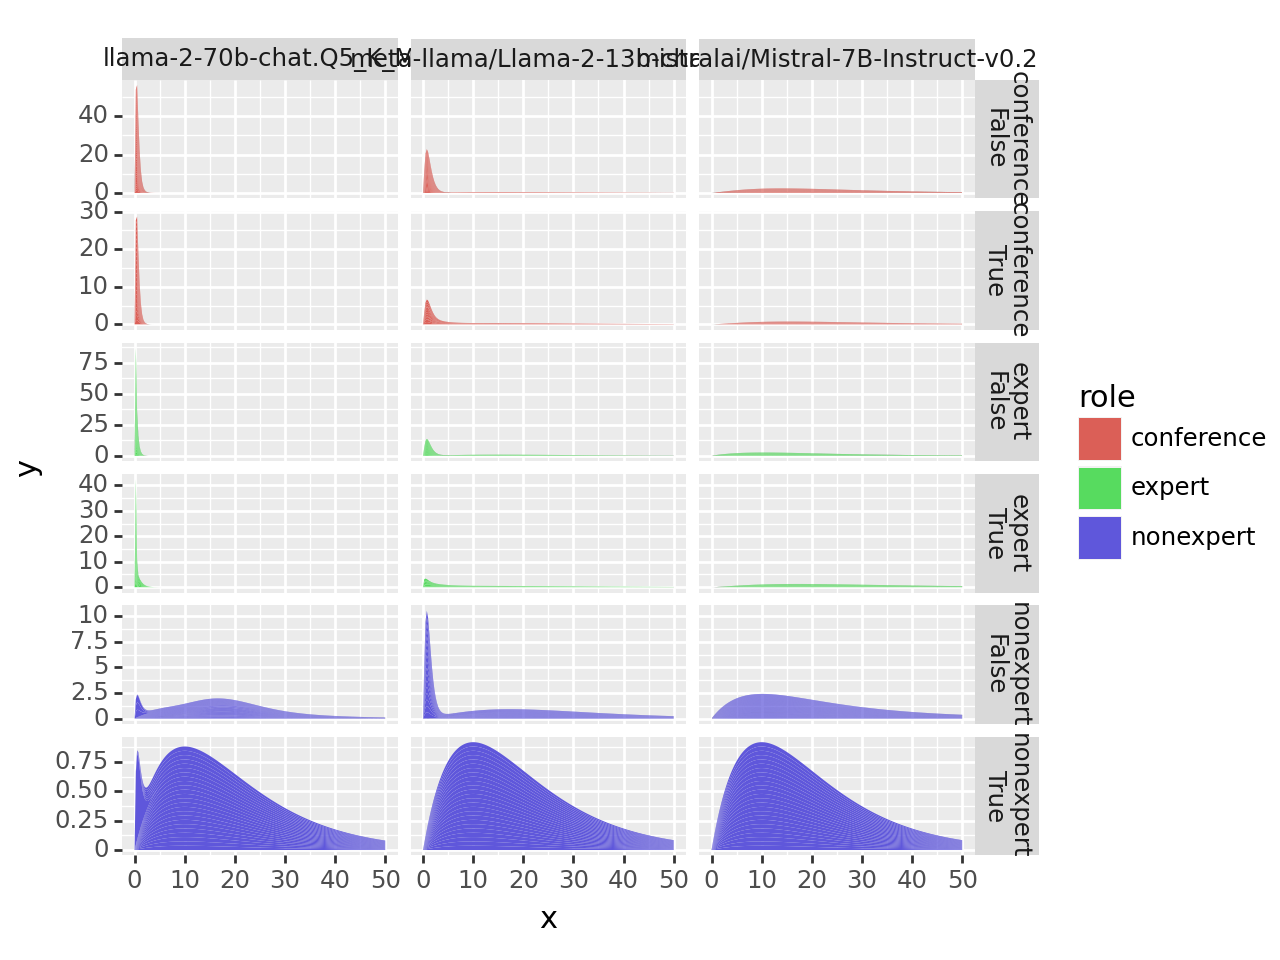

<Figure Size: (640 x 480)>

In [150]:
from scipy.stats import gamma
import numpy as np

x_values = np.linspace(0, 50, 200)
pdf_df = pd.DataFrame()
for index, row in priors_df.iterrows():
    if row['dist'] == 'gamma':
        shape = row['params.shape']
        scale = row['params.scale']
        pdf_values = gamma.pdf(x_values, shape, scale=scale)
        pdf_df = pd.concat([pdf_df, pd.DataFrame({'x': x_values, 'y': pdf_values, 'id': index,
                                                  'model': row['model'], 'role': row['role'],
                                                  'shelf': row['shelf'], 'roulette': row['roulette']})])

(
    ggplot(pdf_df)
    + aes('x', 'y', fill='role', group='id')
    + geom_area(position='stack')
    + facet_grid('role + shelf ~ model', scales='free_y')
)

In [151]:
from modules.evaluator import PriorEvaluator



### Normal-inverse-gamma distribution

Plotting the density of a normal-inverse-gamma distribution is not so easy, because it is a multivariate distribution. Let's look at the means and the scales/precision for now.

In [152]:
priors_df.head()

,field,target,dist,model,role,shelf,roulette,timestamp,params.mean,params.precision,params.shape,params.scale
0,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0
1,New York City,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,0.5,0.01,2.0,5.0
2,London,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,1.5
3,Sydney,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,21.0,0.01,5.0,5.0
4,Cape Town,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,18.5,0.01,2.0,5.0


/home/david/quantllm/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 5 rows containing missing values.


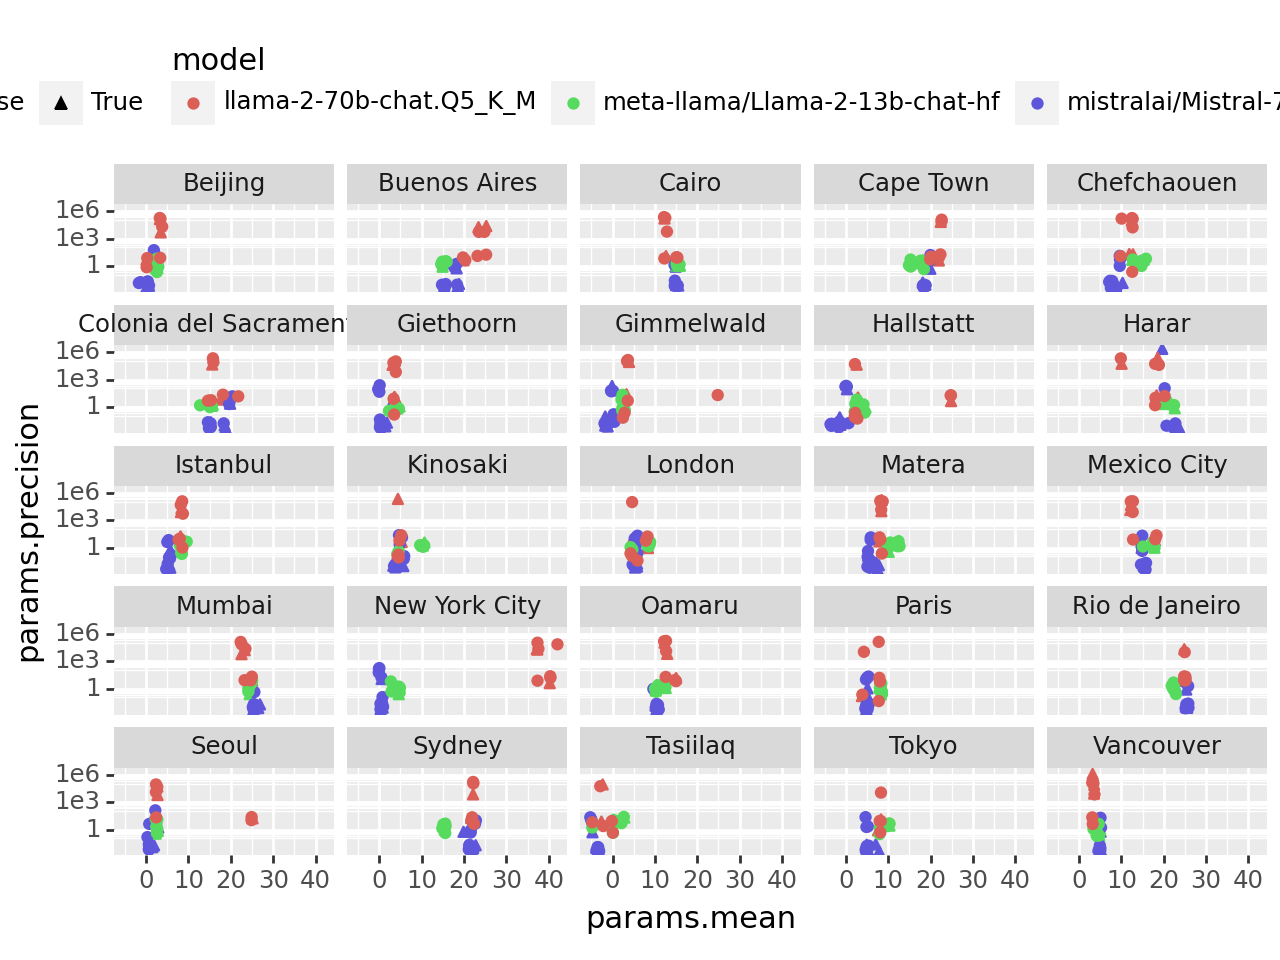

<Figure Size: (640 x 480)>

In [153]:
(
    ggplot(priors_df[(priors_df.target == 'temperature')]) +
    aes('params.mean', 'params.precision', shape='shelf', colour='model') +
    geom_jitter() +
    # geom_text(aes(label='field')) +
    facet_wrap('~field', ncol=5) +
    scale_y_log10() +
    theme(legend_position='top')
)

# Expected predictive loss

In [154]:
weather_df

,temperature,precipitation,city,address,latitude,longitude
date,,,,,,
2010-12-01,10.069083,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-02,13.787833,44.100002,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-03,13.273248,0.400000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-04,9.221168,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-05,9.531584,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
...,...,...,...,...,...,...
2023-12-27,0.345667,0.000000,Seoul,"서울특별시, 대한민국",37.566679,126.978291
2023-12-28,0.141500,0.000000,Seoul,"서울특별시, 대한민국",37.566679,126.978291
2023-12-29,-0.002250,0.000000,Seoul,"서울특별시, 대한민국",37.566679,126.978291


In [155]:
priors_df

,field,target,dist,model,role,shelf,roulette,timestamp,params.mean,params.precision,params.shape,params.scale
0,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.00
1,New York City,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,0.5,0.01,2.0,5.00
2,London,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,1.50
3,Sydney,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,21.0,0.01,5.0,5.00
4,Cape Town,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,18.5,0.01,2.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1545,Istanbul,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,False,True,2024-02-01 19:08:49,NaN,NaN,2.5,0.25
1546,Vancouver,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,False,True,2024-02-01 19:08:49,NaN,NaN,2.5,0.25
1547,Cairo,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,False,True,2024-02-01 19:08:49,NaN,NaN,2.5,0.25
1548,Buenos Aires,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,False,True,2024-02-01 19:08:49,NaN,NaN,2.5,0.25


In [156]:
set(priors_df.model)

{'llama-2-70b-chat.Q5_K_M',
 'meta-llama/Llama-2-13b-chat-hf',
 'mistralai/Mistral-7B-Instruct-v0.2'}

In [162]:
from modules.evaluator import PriorEvaluator
from sklearn.model_selection import train_test_split

likelihood = {'normal_inverse_gamma': 'norm', 'gamma': 'exp'}
parameters = {'normal_inverse_gamma': ['mean', 'precision', 'shape', 'scale'],
              'gamma': ['shape', 'scale']}
# train_test_split(X, y, test_size=0.2, random_state=42)

results_list = []
for index, row in priors_df.iterrows():
    family = likelihood[row['dist']]
    city, target = row['field'], row['target']
    param_names = parameters[row['dist']]
    train, test = train_test_split(weather_df[weather_df.city==city][target],
                                   test_size=0.1, random_state=42)
    param_dict = {key: row[f'params.{key}'] for key in param_names}
    evaluator = PriorEvaluator(family=family, train_data=train, test_data=test,
                               **param_dict)
    sample_sizes = np.unique(np.logspace(np.log2(2), np.log2(len(train)/2), 20, base=2, dtype=int))
    loss_df = pd.DataFrame(evaluator.evaluate(sample_sizes))
    loss_df = loss_df.assign(**row.to_dict())
    loss_df['index'] = index
    results_list.append(loss_df)
    
results_df = pd.concat(results_list, ignore_index=True)

In [163]:
results_df.head()

,n,loss,field,target,dist,model,role,shelf,roulette,timestamp,params.mean,params.precision,params.shape,params.scale,index
0,2,3.020905,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0,0
1,3,2.597533,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0,0
2,4,2.579098,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0,0
3,5,2.676541,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0,0
4,6,2.784383,Tokyo,temperature,normal_inverse_gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:01:54,5.0,0.01,3.0,2.0,0


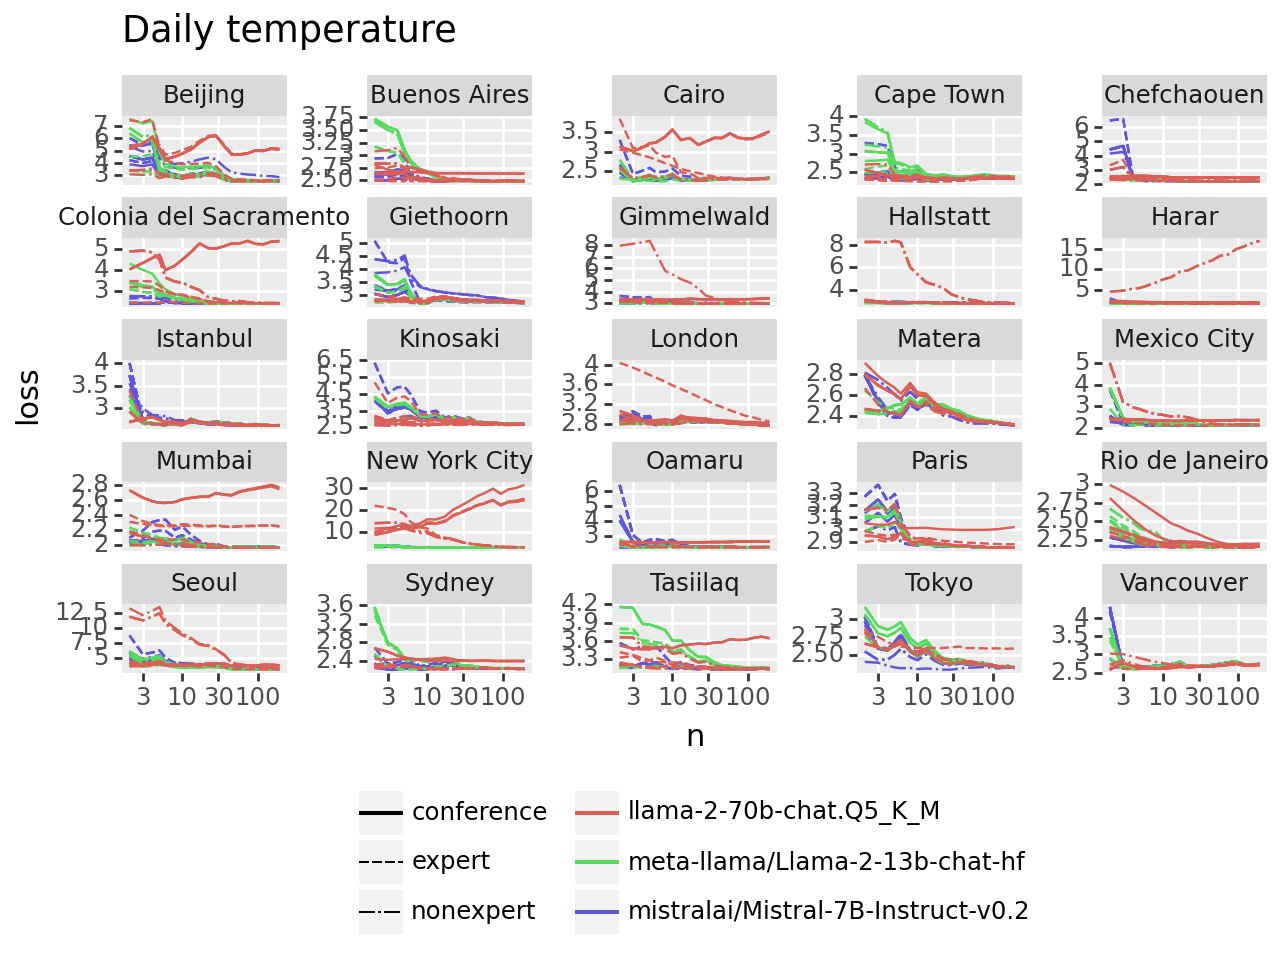

<Figure Size: (640 x 480)>

In [164]:
(
    ggplot(results_df[results_df.target == 'temperature']) + 
    aes('n', 'loss', colour='model', group='index') + 
    geom_line(aes(linetype='role')) + 
    facet_wrap('~ field', scales='free_y') + 
    scale_x_log10(minor_breaks = None) +
    scale_y_continuous(minor_breaks = None) +
    theme(legend_position='bottom', legend_title=element_blank()) +
    guides(colour = guide_legend(nrow=3, byrow=True),
           linetype = guide_legend(nrow=3)) +
    ggtitle('Daily temperature')
)

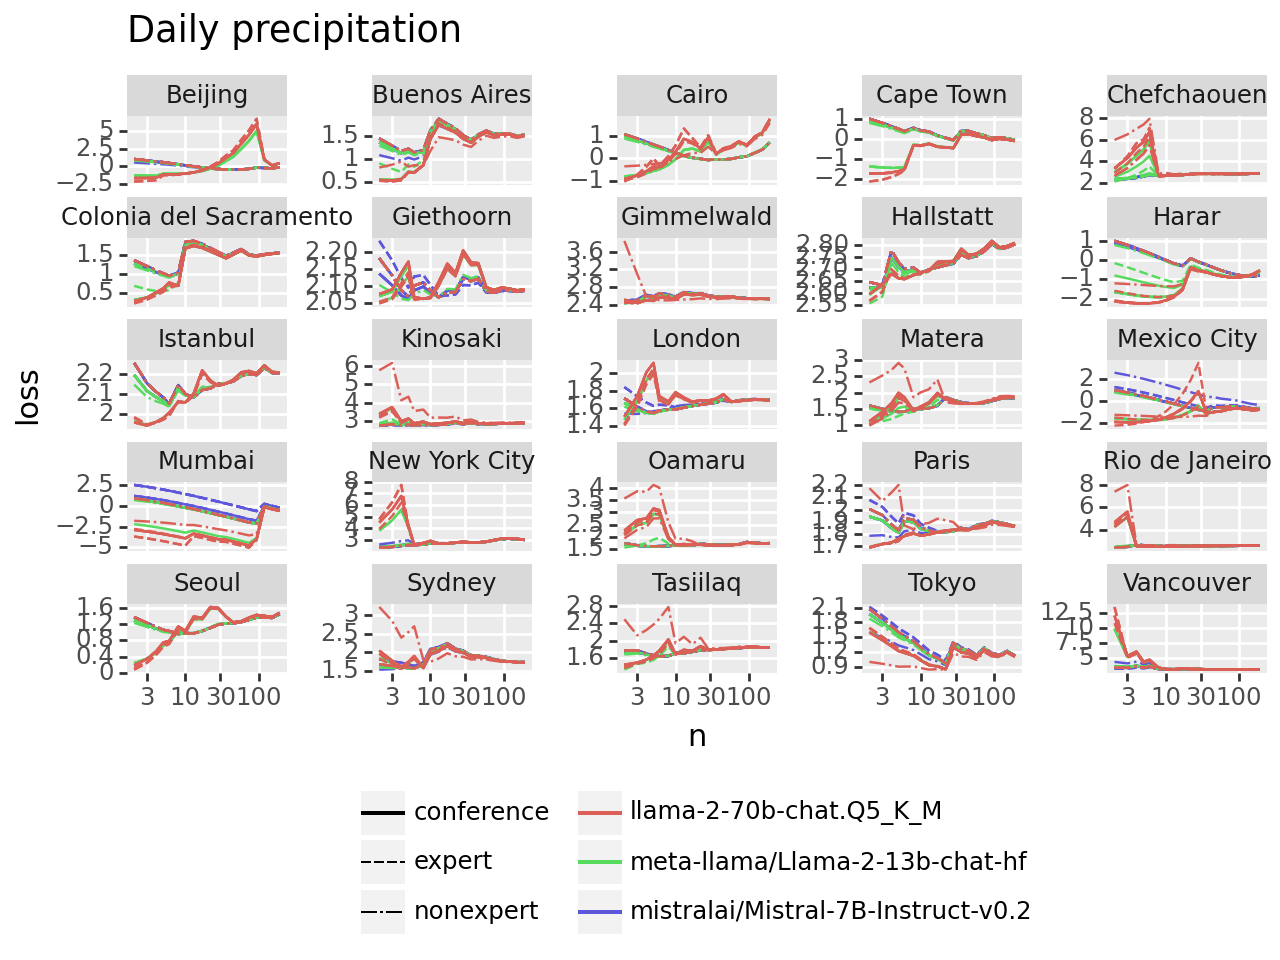

<Figure Size: (640 x 480)>

In [165]:
(
    ggplot(results_df[results_df.target == 'precipitation']) + 
    aes('n', 'loss', colour='model', group='index') + 
    geom_line(aes(linetype='role')) + 
    facet_wrap('~ field', scales='free_y') + 
    scale_x_log10(minor_breaks = None) +
    scale_y_continuous(minor_breaks = None) +
    theme(legend_position='bottom', legend_title=element_blank()) +
    guides(colour = guide_legend(nrow=3, byrow=True),
           linetype = guide_legend(nrow=3)) +
    ggtitle('Daily precipitation')
)

In [161]:
results_df[(results_df.target == 'precipitation') &
           (results_df.field == 'Harar')].sort_values('loss')

,n,loss,field,target,dist,model,role,shelf,roulette,timestamp,params.mean,params.precision,params.shape,params.scale,index
27742,5,-2.250858,Harar,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,False,True,2024-02-01 19:08:49,NaN,NaN,2.5,0.25,1541
22342,5,-2.250858,Harar,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,False,False,2024-02-01 18:57:16,NaN,NaN,2.5,0.25,1241
25042,5,-2.250858,Harar,precipitation,gamma,llama-2-70b-chat.Q5_K_M,conference,True,False,2024-02-01 19:02:56,NaN,NaN,2.5,0.25,1391
25942,5,-2.249532,Harar,precipitation,gamma,llama-2-70b-chat.Q5_K_M,expert,False,True,2024-02-01 19:05:27,NaN,NaN,2.0,0.25,1441
20542,5,-2.249532,Harar,precipitation,gamma,llama-2-70b-chat.Q5_K_M,expert,False,False,2024-02-01 18:53:50,NaN,NaN,2.0,0.25,1141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6138,1,1.260135,Harar,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,conference,False,False,2024-02-01 18:10:10,NaN,NaN,2.0,10.00,341
24138,1,1.260135,Harar,precipitation,gamma,llama-2-70b-chat.Q5_K_M,nonexpert,True,False,2024-02-01 19:01:20,NaN,NaN,2.0,10.00,1341
10638,1,1.260135,Harar,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,nonexpert,False,True,2024-02-01 18:12:46,NaN,NaN,2.0,10.00,591
4338,1,1.260135,Harar,precipitation,gamma,mistralai/Mistral-7B-Instruct-v0.2,expert,False,False,2024-02-01 18:09:19,NaN,NaN,2.0,10.00,241
